In [16]:
#Imports

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.convolutional import Conv2D

In [2]:
#Global Variables
train_dir = 'data/train/'
new_size = (256,256)

In [3]:
im_mask = Image.open(train_dir+'3594_mask.png')
im_sat = Image.open(train_dir+'3594_sat.jpg')

resized_mask = im_mask.resize(new_size)
resized_sat = im_sat.resize(new_size)


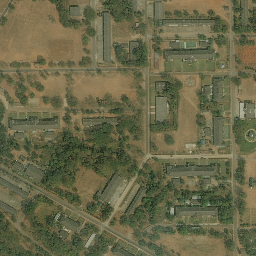

In [4]:
resized_sat

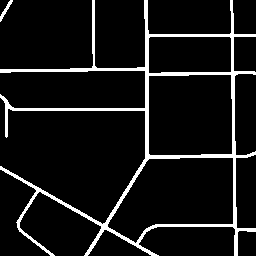

In [5]:
resized_mask

In [6]:
resized_mask_matrix = np.asarray(resized_mask.convert("L"))
resized_sat_matrix = np.asarray(resized_sat.convert("RGB"))

In [7]:
value = 0
while value == 0:
    pos = tuple(np.random.choice(256,2))
    value = resized_mask_matrix[pos]

print(pos)

(69, 137)


In [8]:
def is_valid_center(pos, patch_size, image_size):
    delta = patch_size//2
    return not (pos[0]-delta < 0 or pos[0] + delta > image_size or pos[1] - delta < 0 or pos[1] + delta > image_size)

def get_patch(mask, image, patch_size=32):
    value = 0
    pos = (0,0)
    while value == 0 or not is_valid_center(pos, patch_size, image.shape[0]):
        pos = tuple(np.random.choice(256,2))
        value = resized_mask_matrix[pos]
    return mask[pos[0]-patch_size//2 : pos[0]+patch_size//2, pos[1]-patch_size//2 : pos[1]+patch_size//2  ], image[pos[0]-patch_size//2 : pos[0]+patch_size//2, pos[1]-patch_size//2 : pos[1]+patch_size//2, :  ]

    

In [9]:
for i in range(100):
    get_patch(resized_mask_matrix, resized_sat_matrix)

In [10]:
mask_patch = Image.fromarray(resized_mask_matrix.astype('uint8'), 'L')
image_patch = Image.fromarray(resized_sat_matrix.astype('uint8'), 'RGB')

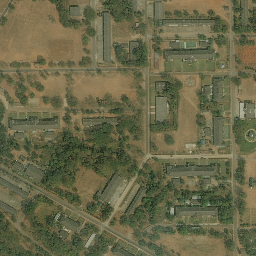

In [11]:
image_patch

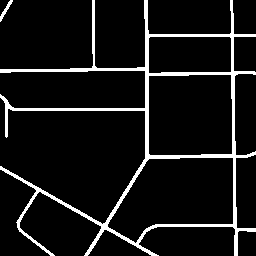

In [12]:
mask_patch

In [13]:
#Prepare data
np.random.seed(44)

X_train, Y_train = [], []

for i in range(100):
    mask_patch, im_patch = get_patch(resized_mask_matrix, resized_sat_matrix)
    X_train.append(im_patch)
    Y_train.append(mask_patch)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(X_train.shape)

(100, 32, 32, 3)


In [20]:
# Model definition
activation = "relu"
num_layers = 10
loss_function = "logcosh"
optimizer_algorithm = "adam"

In [32]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop

from losses import bce_dice_loss, dice_loss, weighted_bce_dice_loss, weighted_dice_loss, dice_coeff

In [46]:
def get_unet_256(input_shape=(256, 256, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])

    return model



In [44]:
Y_train.reshape(100,32,32,1).shape

(100, 32, 32, 1)

In [47]:
model = get_unet_256(input_shape=(32,32,3),num_classes=1)
model.summary()
model.fit(X_train, Y_train.reshape(100,32,32,1), epochs=100, shuffle=True, verbose=1, batch_size=64)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 32, 32, 32)   896         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_200 (BatchN (None, 32, 32, 32)   128         conv2d_207[0][0]                 
__________________________________________________________________________________________________
activation_213 (Activation)     (None, 32, 32, 32)   0           batch_normalization_200[0][0]    
__________________________________________________________________________________________________
conv2d_208

Epoch 1/100
100/100 [==============================] - 20s 197ms/step - loss: -17.8209 - dice_coeff: 1.1866
Epoch 2/100
100/100 [==============================] - 17s 168ms/step - loss: -44.9010 - dice_coeff: 1.3399
Epoch 3/100
100/100 [==============================] - 16s 162ms/step - loss: -68.7047 - dice_coeff: 1.4131
Epoch 4/100
100/100 [==============================] - 16s 159ms/step - loss: -91.3720 - dice_coeff: 1.4866
Epoch 5/100
100/100 [==============================] - 16s 157ms/step - loss: -108.0920 - dice_coeff: 1.5206
Epoch 6/100
100/100 [==============================] - 16s 161ms/step - loss: -124.3803 - dice_coeff: 1.5795
Epoch 7/100
100/100 [==============================] - 17s 172ms/step - loss: -137.5437 - dice_coeff: 1.6058
Epoch 8/100
100/100 [==============================] - 16s 158ms/step - loss: -156.6276 - dice_coeff: 1.6612
Epoch 9/100
100/100 [==============================] - 16s 163ms/step - loss: -170.5834 - dice_coeff: 1.7020
Epoch 10/100
100/100 [=

100/100 [==============================] - 16s 157ms/step - loss: -365.6461 - dice_coeff: 1.9757
Epoch 76/100
100/100 [==============================] - 16s 157ms/step - loss: -367.5171 - dice_coeff: 1.9764
Epoch 77/100
100/100 [==============================] - 16s 157ms/step - loss: -369.5104 - dice_coeff: 1.9772
Epoch 78/100
100/100 [==============================] - 16s 158ms/step - loss: -370.4613 - dice_coeff: 1.9775
Epoch 79/100
100/100 [==============================] - 15s 154ms/step - loss: -370.3256 - dice_coeff: 1.9772
Epoch 80/100
100/100 [==============================] - 17s 168ms/step - loss: -369.3325 - dice_coeff: 1.9757
Epoch 81/100
100/100 [==============================] - 16s 158ms/step - loss: -367.1703 - dice_coeff: 1.9732
Epoch 82/100
100/100 [==============================] - 17s 172ms/step - loss: -370.8396 - dice_coeff: 1.9769
Epoch 83/100
100/100 [==============================] - 16s 156ms/step - loss: -373.3338 - dice_coeff: 1.9777
Epoch 84/100
100/100 [=

In [21]:
# Model

model = Sequential()
model.add(Dense(256, input_shape=(32*32*3,)))
model.add(Activation(activation))
for i in range(num_layers):
    model.add(Dense(256))
    model.add(Activation(activation))
model.add(Dense(32*32))
model.add(Activation(activation))

model.summary()

model.compile(loss=loss_function, optimizer=optimizer_algorithm, metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               786688    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
__________

In [22]:
print(Y_train.reshape(100,32*32).shape)
model.fit(X_train.reshape(100,32*32*3), Y_train.reshape(100,32*32), epochs=1000, shuffle=True, verbose=1, batch_size=64)


(100, 1024)
Epoch 1/1000
100/100 [==============================] - 1s 11ms/step - loss: 37.4633 - acc: 0.0000e+00
Epoch 2/1000
100/100 [==============================] - 0s 698us/step - loss: 37.2442 - acc: 0.0000e+00
Epoch 3/1000
100/100 [==============================] - 0s 729us/step - loss: 37.2070 - acc: 0.0000e+00
Epoch 4/1000
100/100 [==============================] - 0s 798us/step - loss: 37.2009 - acc: 0.0000e+00
Epoch 5/1000
100/100 [==============================] - 0s 706us/step - loss: 37.1950 - acc: 0.0000e+00
Epoch 6/1000
100/100 [==============================] - 0s 706us/step - loss: 37.1872 - acc: 0.0000e+00
Epoch 7/1000
100/100 [==============================] - 0s 800us/step - loss: 37.1767 - acc: 0.0000e+00
Epoch 8/1000
100/100 [==============================] - 0s 710us/step - loss: 37.1627 - acc: 0.0000e+00
Epoch 9/1000
100/100 [==============================] - 0s 712us/step - loss: 37.1298 - acc: 0.0000e+00
Epoch 10/1000
100/100 [==============================

KeyboardInterrupt: 

In [58]:
Y = model.predict(X_train, batch_size=10000)
k = 0
Y = Y.reshape(100,32,32)
Y = Y > 0.5

In [61]:
print(Y[2].sum())

167


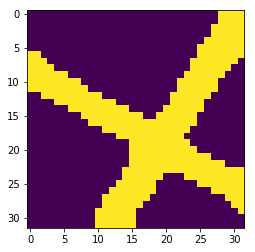

In [65]:
%matplotlib inline
num=10
plt.imshow(Y[num])

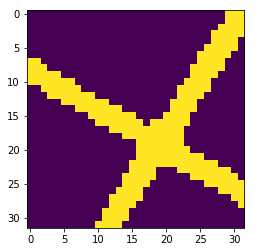

In [66]:
plt.imshow(Y_train[num])

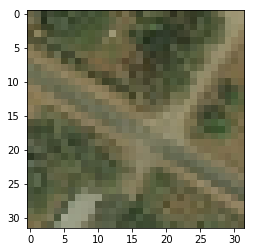

In [67]:
plt.imshow(X_train[num])

In [68]:
#Prepare data
np.random.seed(222)

X_train, Y_train = [], []

for i in range(100):
    mask_patch, im_patch = get_patch(resized_mask_matrix, resized_sat_matrix)
    X_train.append(im_patch)
    Y_train.append(mask_patch)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Y = model.predict(X_train, batch_size=10000)
k = 0
Y = Y.reshape(100,32,32)
Y = Y > 0.5

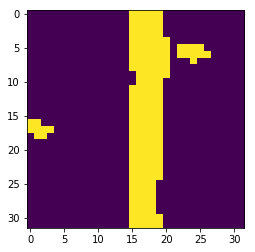

In [85]:
%matplotlib inline
num=25
plt.imshow(Y[num])

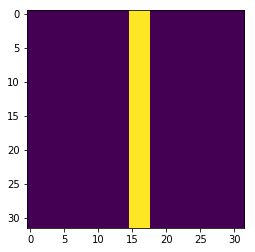

In [86]:
plt.imshow(Y_train[num])

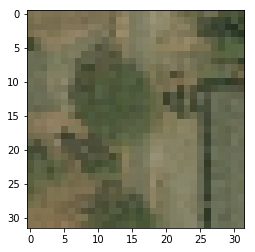

In [87]:
plt.imshow(X_train[num])